In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from torch.distributions import MultivariateNormal

In [2]:
class score_nn(torch.nn.Module):
    def __init__(self, x_dim, hidden_dim):
        super(score_nn, self).__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        
        self.activation = nn.ELU()
        
        self.layer_input = nn.Linear(self.x_dim + 1, self.hidden_dim, bias=True)
        self.layer_1 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layer_2 = nn.Linear(self.hidden_dim, self.hidden_dim, bias=True)
        self.layerout = nn.Linear(self.hidden_dim, x_dim, bias=True)
                
    def forward(self, x,t):
        z_in = torch.concat((x,t),dim=2)
        h = self.layer_input(z_in)
        h_temp = self.activation(self.layer_1(h)) 
        h_temp = self.activation(self.layer_2(h_temp)) 
        h = h_temp + h 
        z_out = self.layerout(h) 
        return z_out

In [3]:
N = 2000 # number of samples
T = 100  # number of time steps
n = 2 # system dimension
m = 1 # control dimension

tf = 1.0 # time horizon
dt = tf/T # time step

n_sigma = 1 # noise level

A = torch.tensor([[0.0, 1.0],[0.0, 0.0]])
B = torch.tensor([[0.0],[1.0]])

In [4]:
x_0 = MultivariateNormal(torch.zeros(n), torch.eye(n)).sample((N,))
y = MultivariateNormal(torch.tensor([1.0,1.0]), torch.eye(n)).sample((N,))

In [5]:
X_f = torch.zeros((T, N, n))
W_f = torch.zeros((T, N, m))


X_f[0] = x_0

t = torch.linspace(0.0, tf, T).reshape(-1,1) # shape (T,1)

t_N = torch.linspace(0.0, tf, T).repeat(N,1).reshape(N,T,1).permute(1,0,2) # shape (T,N,1)

In [6]:
for i in range(T):
    W_f[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))

In [7]:
# W_f[:,:,0] = 0.0
W_f = torch.cat((torch.zeros((T,N,1)), W_f), dim=2)


In [8]:
A_t = torch.zeros((T, N, n, n))
B_t = torch.zeros((T, N, n, n))

A_t[:,:,0,0] = 2*t_N[:,:,0]**3 - 3*t_N[:,:,0]**2 + 1
A_t[:,:,0,1] = t_N[:,:,0]**3 - 2*t_N[:,:,0]**2 + t_N[:,:,0]
A_t[:,:,1,0] = 6*t_N[:,:,0]**2 - 6*t_N[:,:,0]
A_t[:,:,1,1] = 1 + 2*t_N[:,:,0] - 3*t_N[:,:,0]**2

B_t[:,:,0,0] = 3*t_N[:,:,0]**2 - 2*t_N[:,:,0]**3
B_t[:,:,0,1] = t_N[:,:,0]**3 - t_N[:,:,0]**2
B_t[:,:,1,0] = 6*t_N[:,:,0] - 6*t_N[:,:,0]**2
B_t[:,:,1,1] = -2*t_N[:,:,0] + 3*t_N[:,:,0]**2

Sigma_t = torch.zeros((T, N, n, n))
Sigma_t[:,:,0,0] = t_N[:,:,0]**3/3
Sigma_t[:,:,0,1] = -t_N[:,:,0]**2/2
Sigma_t[:,:,1,0] = -t_N[:,:,0]**2/2
Sigma_t[:,:,1,1] = t_N[:,:,0]

Sigma_reshaped = Sigma_t.reshape(-1, n, n)  # Shape (T*N, 2, 2)

## check these lines
# Vectorize the sqrtm function to apply it across all (2, 2) matrices
sqrtm_vectorized = np.vectorize(sp.linalg.sqrtm, signature='(m,n)->(m,n)')
sqrt_Sigma_reshaped = sqrtm_vectorized(Sigma_reshaped)

# Reshape back to the original shape (T, N, 2, 2)
sqrt_Sigma= sqrt_Sigma_reshaped.reshape(T, N, n, n)

In [9]:
X_f = torch.einsum('tnij,tnj->tni', A_t, x_0.unsqueeze(0).repeat(T,1,1)) + torch.einsum('tnij,tnj->tni', B_t, y.unsqueeze(0).repeat(T,1,1)) + n_sigma * torch.einsum('tnij,tnj->tni', torch.Tensor(sqrt_Sigma), W_f)

In [10]:
print(X_f[-1,:,:].mean(dim = 0))
print(X_f[-1,:,:].std(dim = 0))

tensor([1.0008, 1.0120])
tensor([1.0076, 0.9812])


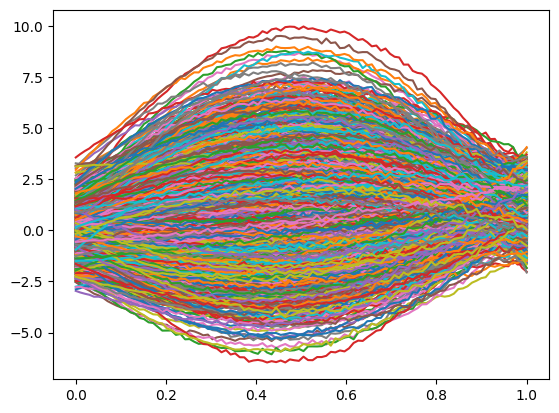

In [11]:
for i in range(N):
    plt.plot(t_N[:,i,0],X_f[:,i,1])

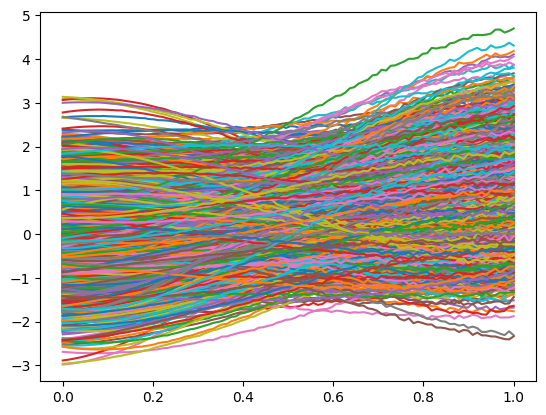

In [12]:
for i in range(N):
    plt.plot(t_N[:,i,0],X_f[:,i,0])

In [13]:
ITERS = 20000
BATCH_SIZE = 32
LR = 1.5e-3

f = score_nn(n,16)
# init_weights(f)
f.train()
optimizer_f = torch.optim.Adam(f.parameters(), lr=LR)
scheduler_f = torch.optim.lr_scheduler.StepLR(optimizer_f, step_size=1000, gamma=0.99)

for i in range(ITERS):
    idx = torch.randperm(N)[:BATCH_SIZE]
    X_train = X_f[:,idx,:]
    t_train = t_N[:,idx,:]  
    Y_train = y[idx,:]
    f_value = f.forward(X_train,t_train) 
    loss = ((f_value-Y_train)*(f_value-Y_train)).mean()
    
    optimizer_f.zero_grad()
    loss.backward()
    optimizer_f.step()
    scheduler_f.step()
    
    if  (i+1)==ITERS or (i+1)%100==0:
        f_value = f.forward(X_f,t_N)
        loss = ((f_value-y)*(f_value-y)).mean()
        
        print("Iteration: %d/%d, loss = %.12f" %(i+1,ITERS,loss.item()))

Iteration: 100/20000, loss = 0.714049041271
Iteration: 200/20000, loss = 0.697250843048
Iteration: 300/20000, loss = 0.694699525833
Iteration: 400/20000, loss = 0.685630619526
Iteration: 500/20000, loss = 0.676710367203
Iteration: 600/20000, loss = 0.664137661457
Iteration: 700/20000, loss = 0.656729996204
Iteration: 800/20000, loss = 0.648229360580
Iteration: 900/20000, loss = 0.639994740486
Iteration: 1000/20000, loss = 0.633252501488
Iteration: 1100/20000, loss = 0.637910783291
Iteration: 1200/20000, loss = 0.630916476250
Iteration: 1300/20000, loss = 0.631800591946
Iteration: 1400/20000, loss = 0.627456903458
Iteration: 1500/20000, loss = 0.623949587345
Iteration: 1600/20000, loss = 0.620992362499
Iteration: 1700/20000, loss = 0.624140620232
Iteration: 1800/20000, loss = 0.621793389320
Iteration: 1900/20000, loss = 0.620393335819
Iteration: 2000/20000, loss = 0.624034821987
Iteration: 2100/20000, loss = 0.614915311337
Iteration: 2200/20000, loss = 0.618708312511
Iteration: 2300/200

In [27]:
N = 2000
T = 1000

t = torch.linspace(0,tf,T).repeat(N).reshape(N,T).T[:,:,None]
dt = tf/T

W_b = torch.zeros((T, N, m))
for i in range(T):
    W_b[i,:,:] = MultivariateNormal(torch.zeros(m), dt*torch.eye(m)).sample((N,))
W_b = torch.cat((torch.zeros((T,N,1)), W_b), dim=2)

X_b = torch.zeros(T,N,n)
X_b[0] = torch.randn(N,n)
#X_b[0] = X[0].clone()
for i in range(0,T-1):
    y_pred = f.forward(X_b[i,None,:,:],t[i,None,:,:])[0]
    # print(torch.inverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])))
    u = (torch.tensor([[1 - t[i,0,0],1]]) @ torch.pinverse(torch.tensor([[(1-t[i,0,0])**3/3, (1-t[i,0,0])**2/2], [(1-t[i,0,0])**2/2, 1-t[i,0,0]]])) @ (y_pred - (torch.tensor([[1, 1-t[i,0,0]],[0, 1]]) @ X_b[i].T).T).T).T
    print(y_pred)
    X_b[i+1] = X_b[i] + (A @ X_b[i].T).T * dt + (B @ u.T).T * dt + n_sigma * W_b[i]

tensor([[1.1295, 0.8967],
        [1.0310, 0.9898],
        [1.0247, 1.0637],
        ...,
        [1.0170, 1.0071],
        [1.2257, 0.8924],
        [0.9954, 1.0224]], grad_fn=<SelectBackward0>)
tensor([[1.1319, 0.8907],
        [1.0284, 0.9910],
        [1.0204, 1.0659],
        ...,
        [1.0218, 1.0034],
        [1.2059, 0.9008],
        [0.9912, 1.0249]], grad_fn=<SelectBackward0>)
tensor([[1.1281, 0.8929],
        [1.0240, 0.9938],
        [1.0230, 1.0647],
        ...,
        [1.0197, 1.0043],
        [1.2125, 0.8984],
        [0.9836, 1.0302]], grad_fn=<SelectBackward0>)
tensor([[1.1223, 0.8975],
        [1.0223, 0.9942],
        [1.0252, 1.0637],
        ...,
        [1.0192, 1.0043],
        [1.2154, 0.8975],
        [0.9841, 1.0287]], grad_fn=<SelectBackward0>)
tensor([[1.1249, 0.8913],
        [1.0182, 0.9967],
        [1.0176, 1.0675],
        ...,
        [1.0221, 1.0021],
        [1.2214, 0.8955],
        [0.9884, 1.0239]], grad_fn=<SelectBackward0>)
tensor([[1.1194

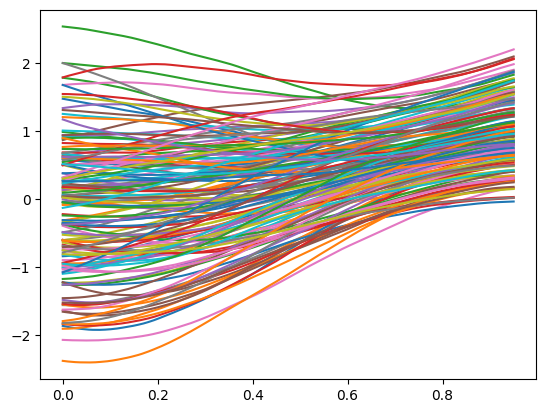

In [18]:
idx = torch.randperm(N)[:150]

for i in idx:
    plt.plot(t[:950,i,0],X_b[:950,i,0].detach().numpy())

(array([0.0230662 , 0.1598158 , 0.42178192, 0.69528113, 0.67221506,
        0.62278748, 0.40036322, 0.22571918, 0.05766553, 0.01647585]),
 array([-3.05115670e-01, -1.64131820e-03,  3.01833034e-01,  6.05307400e-01,
         9.08781767e-01,  1.21225607e+00,  1.51573038e+00,  1.81920481e+00,
         2.12267923e+00,  2.42615342e+00,  2.72962785e+00]),
 <BarContainer object of 10 artists>)

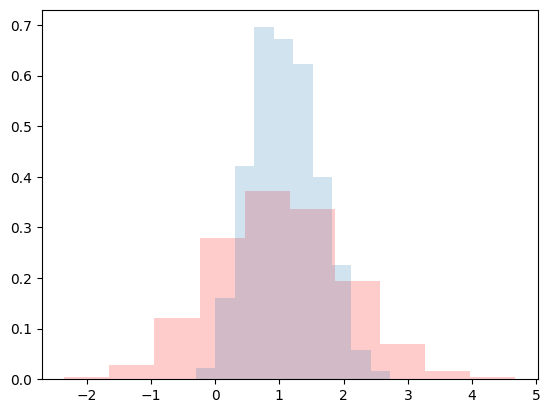

In [25]:
plt.hist(y.numpy()[:,0],alpha=0.2, color='r',density=True)
plt.hist(X_b.detach().numpy()[970,:,0],alpha=0.2, density=True)